In [2]:
DATASET_ROOT="./datasets/"
%pip install -r requirements.txt

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import image_helper
# from SRCNN import SRCNN
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
# assert device == "cuda"

Note: you may need to restart the kernel to use updated packages.


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./srcnn_13_07-v2.csv')
df.tail()

,Unnamed: 0,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
145,145,0.006892,0.003241,145,0.00001,348.977605
146,146,0.006893,0.003242,146,0.00001,348.338651
147,147,0.006891,0.003241,147,0.00001,352.690795
148,148,0.006893,0.003241,148,0.00001,350.171013
149,149,0.006889,0.003241,149,0.00001,353.576943


In [4]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3, use_padding=True, initialization='normal'):
        super(SRCNN, self).__init__()
        self.initialization = initialization
        self.using_padding = use_padding
        padding = [0, 0, 0]
        if use_padding:
            padding = [9 // 2, 5 // 2, 5 // 2]
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=padding[0])
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=padding[1])
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=padding[2])

        # self.conv1 = nn.Conv2d(
        #     3, 64, kernel_size=9, padding=(2, 2)
        # )
        # self.conv2 = nn.Conv2d(
        #     64, 32, kernel_size=1, padding=(2, 2)
        # )
        # self.conv3 = nn.Conv2d(
        #     32, 3, kernel_size=5, padding=(2, 2)
        # )
        
        self.relu = nn.ReLU(inplace=True)
        
        # self.apply(self._init_weights)
        # self._init_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()


In [5]:
model = SRCNN(num_channels=3).to(device)
try:
    model.load_state_dict(torch.load('./srcnn_13_07-v2.pth'))
except:
    model.load_state_dict(torch.load('./srcnn_13_07-v2.pth', map_location=torch.device('cpu')))

In [6]:
image = Image.open(f"{DATASET_ROOT}Set14/monarch.png")

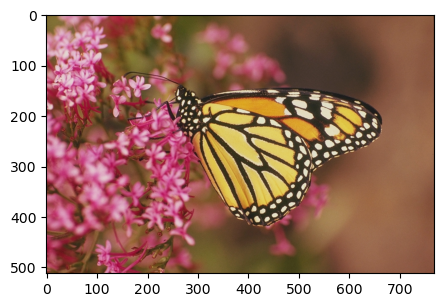

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

/var/folders/5z/jvmv1stj4531scvqz47n7cpc0000gn/T/ipykernel_70452/221402860.py:4: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.LINEAR),
/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


<Figure size 500x500 with 0 Axes>

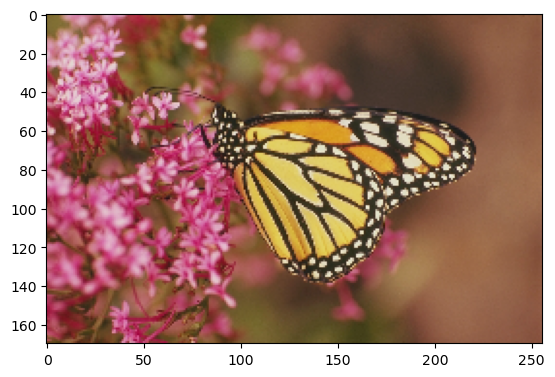

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.LINEAR),
])
low_res_image = transform(image)

plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(low_res_image) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 500x500 with 0 Axes>

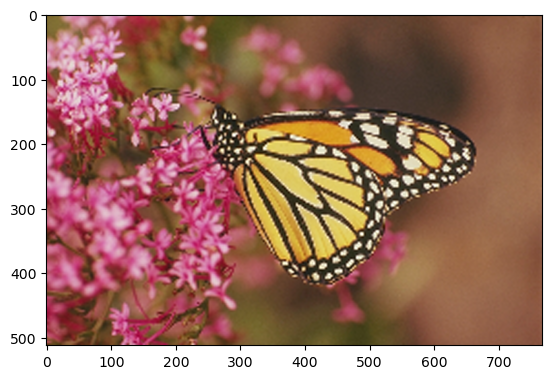

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((image.size[1], image.size[0]), interpolation=Image.BICUBIC)
])
bicubic_image = transform(image)

plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(bicubic_image) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 500x500 with 0 Axes>

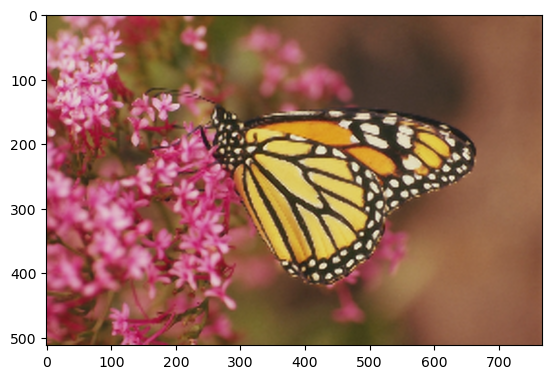

In [10]:
model_image = model(bicubic_image.to(device))
plt.figure(figsize=(5, 5))
image_helper.show_tensor_as_image(model_image) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


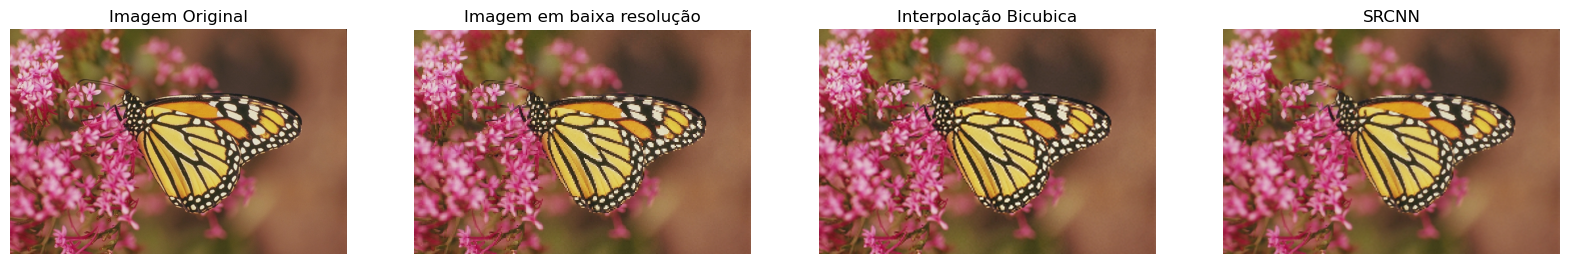

In [11]:
plt.figure(figsize=(20, 20))  # Adjust the width and height as per your preference


plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(low_res_image.detach().numpy().transpose((1, 2, 0)))
plt.title("Imagem em baixa resolução")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(bicubic_image.detach().numpy().transpose((1, 2, 0)))
plt.title("Interpolação Bicubica")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(model_image.detach().numpy().transpose((1, 2, 0)))
plt.title("SRCNN")
plt.axis('off')

plt.show()

In [12]:
#########

In [13]:
psnr = PeakSignalNoiseRatio()

preds = model_image
targets = transforms.ToTensor()(image)
psnr_value = psnr(preds, targets)
print('PSNR =', psnr_value) 

PSNR = tensor(27.9671, grad_fn=<SqueezeBackward0>)


In [14]:
preds = bicubic_image
targets = transforms.ToTensor()(image)
psnr_value = psnr(preds, targets)
print('PSNR =', psnr_value) 

PSNR = tensor(27.4507)


In [15]:
psnr = PeakSignalNoiseRatio()
model_psnr_avg = 0
bicubic_psnr_avg = 0
pathlist = Path(f"{DATASET_ROOT}Set14/").rglob('*.png')
img_count = 0
for path in tqdm(pathlist):
     img_count += 1

     # because path is object not string
     path_in_str = str(path)

     image = Image.open(path_in_str)

     transform = transforms.Compose([
          transforms.ToTensor(),
          # resize image to 33x33 and downsample by BICUBIC interpolation
          transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.BICUBIC),
          # resize image to 256x256
          transforms.Resize((image.size[1], image.size[0]), interpolation=Image.BICUBIC)
     ])
     bicubic_image = transform(image)
     
     model_image = model(bicubic_image.to(device))

     # target for PSNR metric
     targets = transforms.ToTensor()(image)

     # bicubic PSNR
     preds = bicubic_image
     bicubic_psnr_avg += psnr(preds, targets)

     # model PSNR
     preds = model_image
     model_psnr_avg += psnr(preds, targets)

bicubic_psnr_avg = bicubic_psnr_avg / img_count
model_psnr_avg = model_psnr_avg / img_count

print('bicubic_psnr_avg =', bicubic_psnr_avg)
print('model_psnr_avg =', model_psnr_avg)

14it [00:12,  1.12it/s]

bicubic_psnr_avg = tensor(24.4968)
model_psnr_avg = tensor(24.8940, grad_fn=<DivBackward0>)


In [16]:
psnr_df = pd.DataFrame({'Interpolação Bicúbica': [bicubic_psnr_avg.detach().numpy()], 'SRCNN': [model_psnr_avg.detach().numpy()], '': ['PSNR']})
psnr_df.set_index('' ,inplace=True)
psnr_df

,Interpolação Bicúbica,SRCNN
,,
PSNR,24.496826,24.893967


In [17]:
bicubic_psnr_avg

tensor(24.4968)

In [18]:
model_psnr_avg

tensor(24.8940, grad_fn=<DivBackward0>)

In [19]:
##########

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


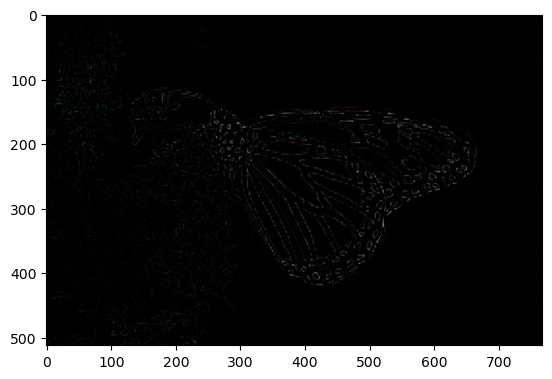

In [20]:
image = Image.open(f"{DATASET_ROOT}Set14/monarch.png")

transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((image.size[1] // 3, image.size[0] // 3), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((image.size[1], image.size[0]), interpolation=Image.BICUBIC)
])
bicubic_image = transform(image)

model_image = model(bicubic_image.to(device))

difference = transforms.ToTensor()(image) - model_image 
image_helper.show_tensor_as_image(difference)